<b><u>Observations</b></u>
<p>1. observation</p>
<p>2. observation</p>
<p>3. observation</p>

In [1]:
# Dependencies
import numpy as np
import random
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wrapper for OpenWeatherMap
# Will use this to view sample JSON API response
import openweathermapy.core as owm

# Dependencies for downloading and uncompressing list of cities from OpenWeatherMap
import urllib.request
import gzip

# Set the seaborn chart style
sns.set()

# Increase the size of the bubble charts
plt.rcParams["figure.figsize"] = [10,8]

In [2]:
# Print out a sample JSON API response
settings = {"units": "imperial", "appid": api_key}
pprint(owm.get_current(2172797, **settings))

{'base': 'stations',
 'clouds': {'all': 75},
 'cod': 200,
 'coord': {'lat': -16.92, 'lon': 145.77},
 'dt': 1521944040,
 'id': 2172797,
 'main': {'humidity': 88,
          'pressure': 1008,
          'temp': 78.8,
          'temp_max': 78.8,
          'temp_min': 78.8},
 'name': 'Cairns',
 'sys': {'country': 'AU',
         'id': 8166,
         'message': 0.004,
         'sunrise': 1521922896,
         'sunset': 1521966245,
         'type': 1},
 'visibility': 5000,
 'weather': [{'description': 'light intensity shower rain',
              'icon': '09d',
              'id': 520,
              'main': 'Rain'}],
 'wind': {'deg': 110, 'speed': 9.17}}


<h1>Download City List</h1>

In [3]:
# This section downloads the list of cities and IDs that OpenWeatherMap uses from their website
# Decided this was more efficient than creating a list of cities using citipy and 
#  latitudes/longitudes since OpenWeatherMap says results will be more accurate if you use IDs instead of names

# File names
city_index_zip_file = "city.list.json.gz"
city_index_json_file = 'city.list.json'

# Download file
urllib.request.urlretrieve ("http://bulk.openweathermap.org/sample/city.list.json.gz", city_index_zip_file)

# Uncompress gzip file to json
inF = gzip.open(city_index_zip_file, 'rb')
outF = open(city_index_json_file, 'wb')
outF.write(inF.read())
inF.close()
outF.close()

# Read json file into a dataframe
city_index_df = pd.read_json(city_index_json_file)

# Print top five rows
city_index_df.head()

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,GorkhÄ�
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of HaryÄ�na
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


<h1>Generate City List</h1>

In [4]:
# This section selects 555 random cities from the above city index dataframe

# Start by creating an empty dataframe
random_city_df = pd.DataFrame(columns=['coord', 'country', 'id', 'name', 'lon', 'lat'])

# Set counter to zero for looping
counter = 0

# Set total number of random cities
total_cities = 555

# Loop while counter is less than number of cities
while counter < total_cities:
    
    # Pick a random row (must be length - 1 since row starts at 0)
    row = random.randint(0, len(city_index_df)-1)
    
    # If ID is already in the dataframe then do nothing and repeat loop
    if any(random_city_df.id == city_index_df['id'][row]):
        pass
    
    # If ID isn't in the dataframe then add that row to the dataframe, including latitude and longitude
    else:
        random_city_df.loc[counter] = city_index_df.iloc[row,:]
        random_city_df.lat[counter] = city_index_df['coord'][row]['lat']
        random_city_df.lon[counter] = city_index_df['coord'][row]['lon']
        counter = counter + 1
        
# Change latitude and longitude columns from object to float
random_city_df[['lat','lon']] = random_city_df[['lat','lon']].apply(pd.to_numeric)

<h1>Weather API Call</h1>

In [5]:
# This section does the API calls from OpenWeatherMap

# Create empty lists for temperature, humidity, cloudiness and windspeed
# This will get added to the dataframe of cities
city_temp_list = []
city_humidity_list = []
city_cloudiness_list = []
city_windspeed_list = []

# Loop through the total number of cities
for index in range(total_cities):
    
    # Print out 
    print(f"Request {index+1} of {total_cities}: {random_city_df['name'][index]}")
    
    # Create the URL
    url = "http://api.openweathermap.org/data/2.5/weather?APPID="+api_key+"&units=imperial&id="+str(random_city_df.id[index])
    
    # Print the URl but mask the api key
    print("http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id="+str(random_city_df.id[index]))

    # Do the API call
    response = requests.get(url)
    
    # Convert API response to JSON
    data = response.json()
    
    # Grab temperature, humidity, cloudiness and windspeed and add it to their respective list    
    city_temp_list.append(data['main']['temp'])
    city_humidity_list.append(data['main']['humidity'])
    city_cloudiness_list.append(data['clouds']['all'])
    city_windspeed_list.append(data['wind']['speed'])

# Add temperature, humidity, cloudiness and windspeed as a column in the dataframe
random_city_df['temp'] = city_temp_list
random_city_df['humidity'] = city_humidity_list
random_city_df['cloudiness'] = city_cloudiness_list
random_city_df['windspeed'] = city_windspeed_list

Request 1 of 555: Lalapasa
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=741884
Request 2 of 555: Deville-les-Rouen
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3021484
Request 3 of 555: Tha Tako
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1605490
Request 4 of 555: San Jose
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1689507
Request 5 of 555: Barskoye-Melechkino
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=527789
Request 6 of 555: Ban Rangsit
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1613769
Request 7 of 555: Dullewala
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1179496
Request 8 of 555: Parcoul
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2988567
Request 9 of 555: Villette-de-Vienne
http://api.openweathermap.org/data/2.5/weather

Request 74 of 555: Puerto Escondido
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3671470
Request 75 of 555: Monasterolo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7799838
Request 76 of 555: Seneca
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4279170
Request 77 of 555: Ocu
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3703786
Request 78 of 555: Niederlauterbach
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2863175
Request 79 of 555: Wyoming
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4917218
Request 80 of 555: HornÃ­ Gruntramovice
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3075387
Request 81 of 555: Krynice
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=767368
Request 82 of 555: BÄ�b al JazÄ«rah
http://api.openweathermap.org/data/2.5/

Request 145 of 555: Lazarevskoye
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=536625
Request 146 of 555: Fort Bragg
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6941080
Request 147 of 555: Campora
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3180935
Request 148 of 555: Rocafort
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6362081
Request 149 of 555: Baselt
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2952284
Request 150 of 555: Breckenridge Hills
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4378291
Request 151 of 555: Tema
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2294700
Request 152 of 555: Muurame
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=645386
Request 153 of 555: Beuren
http://api.openweathermap.org/data/2.5/weather?APPID=xx

Request 218 of 555: Hontoria del Pinar
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3120691
Request 219 of 555: Saint-Herblain
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6434515
Request 220 of 555: Neu Trebendorf
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2863949
Request 221 of 555: Bucelas
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=8012504
Request 222 of 555: Queiriga
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=8013979
Request 223 of 555: Neptune Beach
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4165695
Request 224 of 555: Bierawa
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3103388
Request 225 of 555: Oppens
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2659291
Request 226 of 555: Klau
http://api.openweathermap.org/data/2.5/w

Request 291 of 555: La Joya
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4001850
Request 292 of 555: Jameln
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6558466
Request 293 of 555: Port-Olry
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2135175
Request 294 of 555: Ambattur
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1278840
Request 295 of 555: Bananal
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3470992
Request 296 of 555: Aotou
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1817889
Request 297 of 555: Horwich
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2646542
Request 298 of 555: Rockville
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4841628
Request 299 of 555: Suhbaatar
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units

Request 362 of 555: Huntsville
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4068590
Request 363 of 555: Weyhe
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2809835
Request 364 of 555: Vidnoye
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=473778
Request 365 of 555: Palazzolo sull'Oglio
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6541425
Request 366 of 555: Lindach
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2877572
Request 367 of 555: Aldbrough
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2657561
Request 368 of 555: Altlichtenberg
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2782634
Request 369 of 555: San Cristobal de Segovia
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3110723
Request 370 of 555: Yellowstone County
http://api.openwea

Request 433 of 555: Herbolzheim
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2906205
Request 434 of 555: Seohara
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1256832
Request 435 of 555: Plaine Magnien
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=934169
Request 436 of 555: Bercero
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6362145
Request 437 of 555: Wernigerode
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2810808
Request 438 of 555: Costur
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6357003
Request 439 of 555: Pano Dheftera
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=146225
Request 440 of 555: Hauterives
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3013742
Request 441 of 555: Biar
http://api.openweathermap.org/data/2.5/weather?APP

Request 504 of 555: Tittybong
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2146498
Request 505 of 555: SchwarzmÃ¼hle
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2834706
Request 506 of 555: SÃ£o JoÃ£o de Negrilhos
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=8014398
Request 507 of 555: Parma Heights
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5166184
Request 508 of 555: Chatsworth
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5920470
Request 509 of 555: Larsmo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=648847
Request 510 of 555: Blizejov
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3079212
Request 511 of 555: Stuttgart
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2825297
Request 512 of 555: Montecosaro
http://api.openweathermap.org/

In [6]:
# Export city dataframe as CSV
random_city_df.to_csv("weather_data.csv", encoding='utf-8')

<h1>Print Charts</h1>

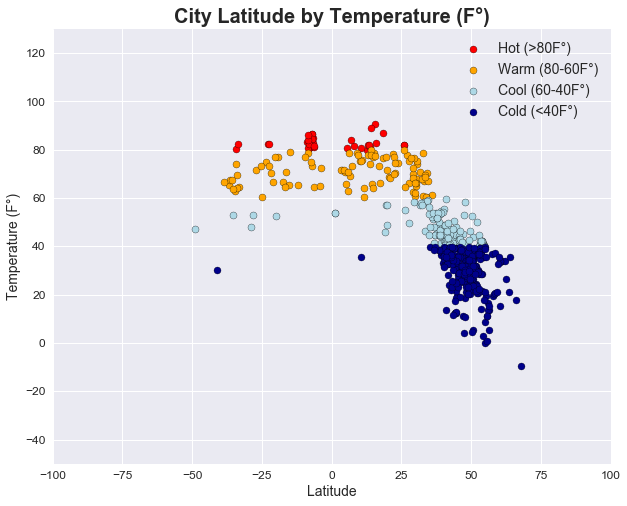

In [7]:
# This section prints a scatter plot of latitude by temperature

# Variables for hot, warm and cool cutoff tempatures
hot_temp = 80
warm_temp = 60
cold_temp = 40

# Create subsets of the dataframe to group by hot, warm, cool and cold temperatures
hot_cities = np.ma.masked_where((random_city_df['temp'] <= hot_temp), random_city_df['temp'])
warm_cities = np.ma.masked_where((random_city_df['temp'] > hot_temp) | (random_city_df['temp'] <= warm_temp), 
                                 random_city_df['temp'])
cool_cities = np.ma.masked_where((random_city_df['temp'] > warm_temp) | (random_city_df['temp'] <= cold_temp), random_city_df['temp'])
cold_cities = np.ma.masked_where((random_city_df['temp'] >= cold_temp), random_city_df['temp'])

# Clear the plot, just in case
plt.clf()

# Create scatter plots
plt.scatter(random_city_df['lat'], hot_cities, marker="o", facecolors='red', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], warm_cities, marker="o", facecolors='orange', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cool_cities, marker="o", facecolors='lightblue', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cold_cities, marker="o", facecolors='darkblue', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Temperature (F\N{DEGREE SIGN})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Temperature (F\N{DEGREE SIGN})", fontsize=14)

# Legend
plt.legend((f'Hot (>{hot_temp}F\N{DEGREE SIGN})',f'Warm ({hot_temp}-{warm_temp}F\N{DEGREE SIGN})', 
            f'Cool ({warm_temp}-{cold_temp}F\N{DEGREE SIGN})',f'Cold (<{cold_temp}F\N{DEGREE SIGN})'),loc='best', prop={'size': 14})

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-50,130)

# Save the figure
plt.savefig("LatByTemp.png")

# Display scatter chart
plt.show()

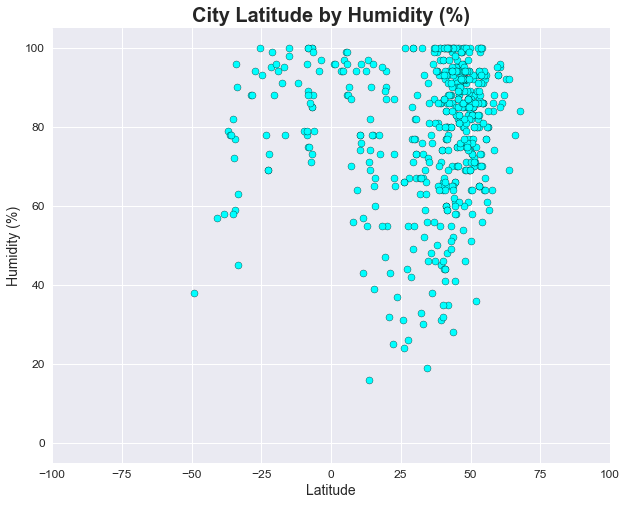

In [8]:
# This section prints a scatter plot of latitude by humidity

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['humidity'], marker="o", facecolors='aqua', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Humidity (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,105)

# Save the figure
plt.savefig("LatByHumidity.png")

# Display scatter chart
plt.show()

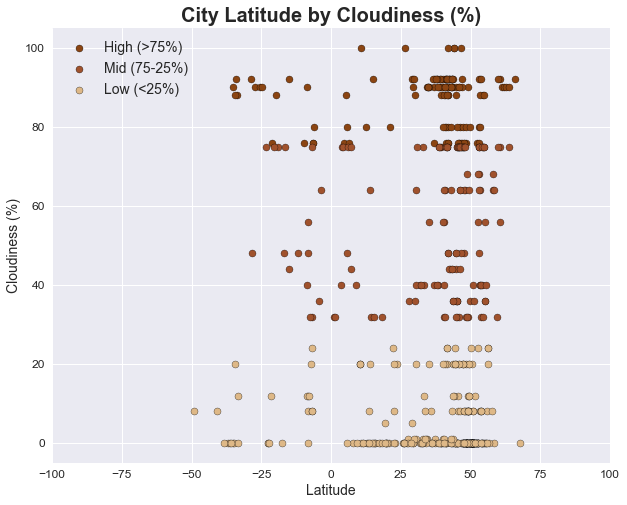

In [9]:
# This section prints a scatter plot of latitude by cloudiness

# Variables for high, mid and low cutoff levels of cloudiness
high_cloudiness = 75
low_cloudiness = 25

# Create subsets of the dataframe to group by migh, mid and low cloudiness
high_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] <= high_cloudiness), random_city_df['cloudiness'])
mid_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] > high_cloudiness) | 
                                      (random_city_df['cloudiness'] <= low_cloudiness), 
                                      random_city_df['cloudiness'])
low_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] >= low_cloudiness), random_city_df['cloudiness'])

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], high_cloud_cities, marker="o", facecolors='saddlebrown', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], mid_cloud_cities, marker="o", facecolors='sienna', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], low_cloud_cities, marker="o", facecolors='burlywood', edgecolors="black", alpha=1)

plt.legend((f'High (>{high_cloudiness}%)', f'Mid ({high_cloudiness}-{low_cloudiness}%)', 
            f'Low (<{low_cloudiness}%)'),loc='best', prop={'size': 14})

# Create a title, x label, and y label
plt.title("City Latitude by Cloudiness (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,105)

# Save the figure
plt.savefig("LatByCloudiness.png")

# Display scatter plot
plt.show()

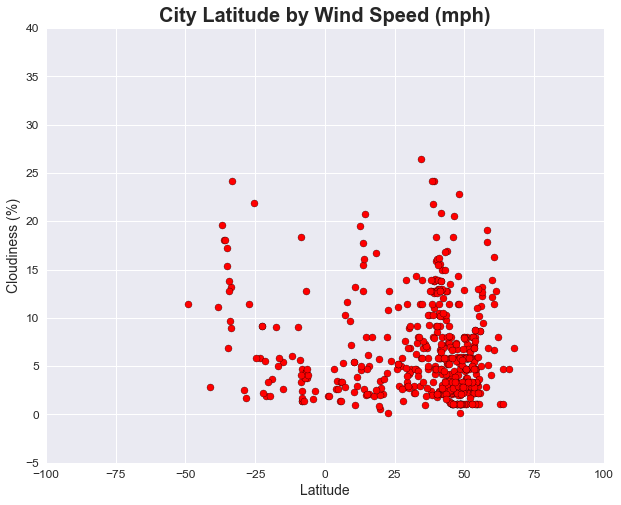

In [10]:
# This section prints a scatter plot of latitude by windspeed

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['windspeed'], marker="o", facecolors='red', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Wind Speed (mph)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,40)

# Save the figure
plt.savefig("LatByWindspeed.png")

# Display scatter plot
plt.show()